In [4]:
%autosave 120
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import re
from scipy.stats import norm

Autosaving every 120 seconds


In [5]:
match_data=pd.read_csv('match_data.csv')

core=pd.DataFrame(dict(match_data[['city','date','season','team1','team2','toss_winner','toss_decision','winner','win_by_runs','win_by_wickets','eliminator','dl_applied','result','overs','player_of_match','venue','first_bat_team','first_bowl_team','first_bat_score','second_bat_score']]))
print(core.info())
print(core.columns)
core['city'].fillna('Unknown',inplace=True)
core['city']=core['city'].astype(str).apply(lambda x:x.replace('Bengaluru','Bangalore'))
core['date']=pd.to_datetime(core['date'])
#print(core)
f_core=core.set_index(['date','city']).sort_index()

f_core['winner'].fillna(f_core['result'],inplace=True)
#Replace all the Null values with No
f_core['dl_applied'].fillna('No',inplace=True)
#Replace all the D/L with Yes
f_core['dl_applied']=f_core['dl_applied'].apply(lambda x:x.replace('D/L','Yes'))
f_core['winner']=f_core['winner'].replace('tie',f_core['eliminator'])

f_core.replace('Rising Pune Supergiant','Rising Pune Supergiants',inplace=True)
f_core.replace('Delhi Capitals','Delhi Daredevils',inplace=True)
f_core.replace('Deccan Chargers','Sunrisers Hyderabad',inplace=True)
f_core.replace(to_replace =['Delhi Daredevils', 'Sunrisers Hyderabad','Royal Challengers Bangalore','Chennai Super Kings','Mumbai Indians','Kolkata Knight Riders','Kings XI Punjab','Rajasthan Royals','Rising Pune Supergiants','Gujarat Lions','Pune Warriors','Kochi Tuskers Kerala']
                            ,value =['DD','SRH','RCB','CSK','MI','KKR','KXIP','RR','RPS','GL','PW','KTK'],inplace=True) 




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              733 non-null    object 
 1   date              746 non-null    object 
 2   season            746 non-null    int64  
 3   team1             746 non-null    object 
 4   team2             746 non-null    object 
 5   toss_winner       746 non-null    object 
 6   toss_decision     746 non-null    object 
 7   winner            734 non-null    object 
 8   win_by_runs       336 non-null    float64
 9   win_by_wickets    398 non-null    float64
 10  eliminator        8 non-null      object 
 11  dl_applied        19 non-null     object 
 12  result            12 non-null     object 
 13  overs             746 non-null    int64  
 14  player_of_match   742 non-null    object 
 15  venue             746 non-null    object 
 16  first_bat_team    746 non-null    object 
 1

In [6]:
#Delete the result dataframe after using to fill values in winner column 
del f_core['result']
del f_core['eliminator']

In [7]:
#Drop No Result columns as it will affect the Statistics
f_core.drop(f_core[f_core['winner'] == 'no result'].index, inplace = True) 

In [8]:
#Check the shape of the DataFrame
f_core.shape
#(f_core['dl_applied']=='Yes').sum()

(742, 16)

In [9]:
print(f_core.columns)
f_core.info()

Index(['season', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner',
       'win_by_runs', 'win_by_wickets', 'dl_applied', 'overs',
       'player_of_match', 'venue', 'first_bat_team', 'first_bowl_team',
       'first_bat_score', 'second_bat_score'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 742 entries, (Timestamp('2008-04-18 00:00:00'), 'Bangalore') to (Timestamp('2019-05-01 00:00:00'), 'Chennai')
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season            742 non-null    int64  
 1   team1             742 non-null    object 
 2   team2             742 non-null    object 
 3   toss_winner       742 non-null    object 
 4   toss_decision     742 non-null    object 
 5   winner            742 non-null    object 
 6   win_by_runs       336 non-null    float64
 7   win_by_wickets    398 non-null    float64
 8   dl_applied        742 non-null    object 
 9   over

In [10]:
#Filled unknown player_of_matches with 'Not Available'
f_core['player_of_match'].fillna('Not Available',inplace=True)
f_core.info()
#print(f_core['player_of_match'].isna().sum())


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 742 entries, (Timestamp('2008-04-18 00:00:00'), 'Bangalore') to (Timestamp('2019-05-01 00:00:00'), 'Chennai')
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season            742 non-null    int64  
 1   team1             742 non-null    object 
 2   team2             742 non-null    object 
 3   toss_winner       742 non-null    object 
 4   toss_decision     742 non-null    object 
 5   winner            742 non-null    object 
 6   win_by_runs       336 non-null    float64
 7   win_by_wickets    398 non-null    float64
 8   dl_applied        742 non-null    object 
 9   overs             742 non-null    int64  
 10  player_of_match   742 non-null    object 
 11  venue             742 non-null    object 
 12  first_bat_team    742 non-null    object 
 13  first_bowl_team   742 non-null    object 
 14  first_bat_score   742 non-null    float64
 15  sec

In [11]:
f_core.describe()

,season,win_by_runs,win_by_wickets,overs,first_bat_score,second_bat_score
count,742.000000,336.000000,398.000000,742.0,742.000000,742.000000
mean,2013.361186,29.883929,6.251256,20.0,161.545822,148.181941
std,3.327228,27.276827,1.821281,0.0,30.105705,30.478338
min,2008.000000,1.000000,1.000000,20.0,67.000000,44.000000
25%,2011.000000,11.000000,5.000000,20.0,142.000000,132.000000
50%,2013.000000,22.000000,6.000000,20.0,163.000000,150.000000
75%,2016.000000,39.000000,8.000000,20.0,182.000000,169.000000
max,2019.000000,146.000000,10.000000,20.0,263.000000,223.000000


Index(['Bangalore', 'Chandigarh', 'Delhi', 'Kolkata', 'Mumbai', 'Jaipur',
       'Hyderabad', 'Chennai', 'Cape Town', 'Port Elizabeth', 'Durban',
       'Centurion', 'East London', 'Johannesburg', 'Kimberley', 'Bloemfontein',
       'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala', 'Kochi', 'Indore',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi', 'Unknown',
       'Rajkot', 'Kanpur'],
      dtype='object', name='city')

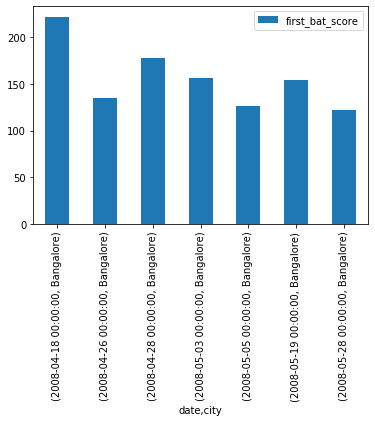

In [12]:
f_core.loc[('2008','Bangalore'),('toss_winner','first_bat_score')].plot(kind='bar')
f_core.index.get_level_values(1).unique()

In [13]:
f_core.head()

season team1 team2 toss_winner toss_decision winner  \
date       city                                                              
2008-04-18 Bangalore     2008   RCB   KKR         RCB         field    KKR   
2008-04-19 Chandigarh    2008  KXIP   CSK         CSK           bat    CSK   
           Delhi         2008    DD    RR          RR           bat     DD   
2008-04-20 Kolkata       2008   KKR   SRH         SRH           bat    KKR   
           Mumbai        2008    MI   RCB          MI           bat    RCB   

                       win_by_runs  win_by_wickets dl_applied  overs  \
date       city                                                        
2008-04-18 Bangalore         140.0             NaN         No     20   
2008-04-19 Chandigarh         33.0             NaN         No     20   
           Delhi               NaN             9.0         No     20   
2008-04-20 Kolkata             NaN             5.0         No     20   
           Mumbai              NaN             5.0         No     20   

                      player_of_match  \
date       city                         
2008-04-18 Bangalore      BB McCullum   
2008-04-19 Chandigarh      MEK Hussey   
           Delhi          MF Maharoof   
2008-04-20 Kolkata          DJ Hussey   
           Mumbai          MV Boucher   

                                                            venue  \
date       city                                                     
2008-04-18 Bangalore                        M Chinnaswamy Stadium   
2008-04-19 Chandigarh  Punjab Cricket Association Stadium, Mohali   
           Delhi                                 Feroz Shah Kotla   
2008-04-20 Kolkata                                   Eden Gardens   
           Mumbai                                Wankhede Stadium   

                      first_bat_team first_bowl_team  first_bat_score  \
date       city                                                         
2008-04-18 Bangalore             KKR             RCB            222.0   
2008-04-19 Chandigarh            CSK            KXIP            240.0   
           Delhi                  RR              DD            129.0   
2008-04-20 Kolkata               SRH             KKR            110.0   
           Mumbai                 MI             RCB            165.0   

                       second_bat_score  
date       city                          
2008-04-18 Bangalore               82.0  
2008-04-19 Chandigarh             207.0  
           Delhi                  132.0  
2008-04-20 Kolkata                112.0  
           Mumbai                 166.0

Text(0.5, 1.0, 'No of Matches Won Per Team')

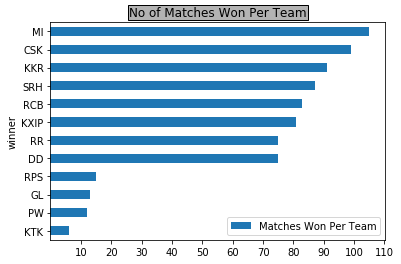

In [14]:
#SHows the Teams who have Won more than 10 matches on any season so far
f_core.groupby(['season','winner']).filter(lambda x: x['winner'].count()>10)['winner']
#No of Matches WOn By each Team
f_core.groupby('winner')['winner'].count().sort_values().plot(kind='barh',xticks=[10,20,30,40,50,60,70,80,90,100,110],legend=True,label='Matches Won Per Team')
plt.title("No of Matches Won Per Team", bbox={'facecolor':'0.7', 'pad':1})



In [15]:
#cities=list(f_core.index.get_level_values(1).unique())
#cities[1]='Punjab'

#f_core.head()

#print(f_core.head())


C:\Users\Devil\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


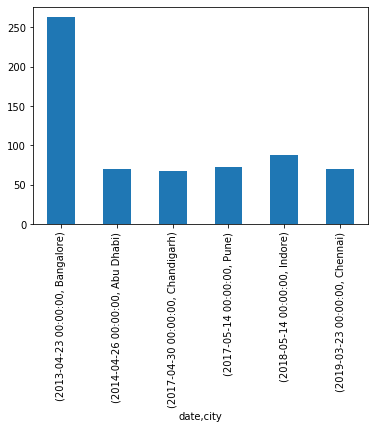

In [16]:
standardized =f_core.groupby('season')['first_bat_score','second_bat_score'].transform(zscore) 
 
# Construct a Boolean Series to identify outliers: outliers
outliers = (standardized['first_bat_score'] < -3) | (standardized['first_bat_score'] > 3)
 
# Filter gapminder_2010 by the outliers: gm_outliers
f_core_outliers = f_core.loc[outliers]
f_core_outliers['first_bat_score'].plot(kind='bar')
#plt.scatter(f_core['season'], f_core['first_bat_score'], label='data', color='green')


#Keeping the Outliers As there are only six outliers none of them are significantly affecting the data and insights.


Text(0.5, 1.0, 'Total Matches Per IPL season')

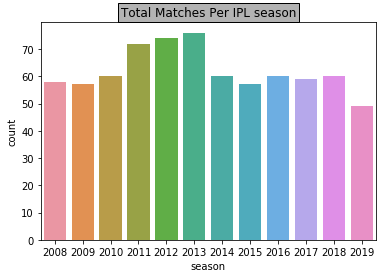

In [17]:
sns.countplot(x='season',data=f_core)
plt.title("Total Matches Per IPL season", bbox={'facecolor':'0.7', 'pad':3})

Text(0.5, 1.0, 'No of Matches Won Overall by each team')

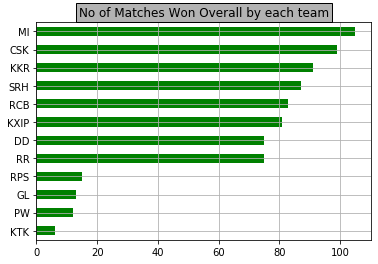

In [18]:
# Count of No of Matches Won by Each team Overall"

data=f_core.winner.value_counts()
#print(type(data2))

data.sort_values(ascending=True).plot(kind='barh',color='green',grid=True)
#plt.xlabel('No of Matches Played')
#plt.ylim((0, 200))
plt.title("No of Matches Won Overall by each team", bbox={'facecolor':'0.7', 'pad':3})



Text(0.5, 1.0, 'No of Matches Played Overall')

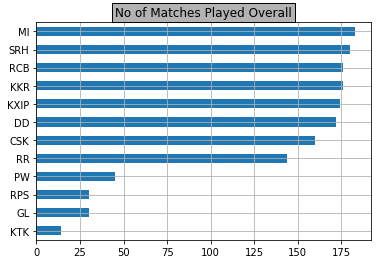

In [19]:
data_1 = f_core.team1.value_counts()
data_2 =f_core.team2.value_counts()
data_3=data_1.add(data_2)
#plt.subplot(1,3,2)
data3_sorted=data_3.sort_values(ascending=True)
#plt.xlabel('No of Matches Won Per team')
data3_sorted.plot(kind='barh',grid=True)
plt.title("No of Matches Played Overall", bbox={'facecolor':'0.7', 'pad':3})
#plt.ylim((0, 200))

Text(0.5, 1.0, 'Overall Percentage of Matches Won Per Team')

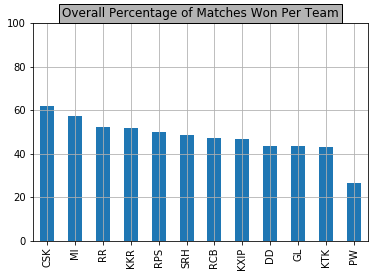

In [20]:
#plt.subplot(1,3,3)
Overall_Percentage=(data/data3_sorted)*100
Overall_Percentage.sort_values(ascending=False).plot(kind='bar',grid=True)
plt.ylim((0, 100))
#plt.xlabel('Overall Percentage of Matches Won/Matches Played')
plt.title("Overall Percentage of Matches Won Per Team", bbox={'facecolor':'0.7', 'pad':3})



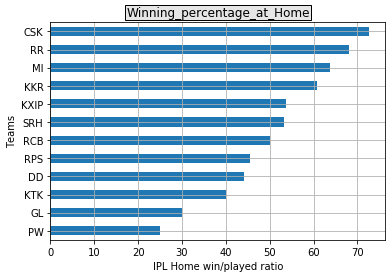

In [21]:
data1=f_core.reset_index()
Teams={'RCB':'Bangalore','CSK':'Chennai','SRH':'Hyderabad','MI':'Mumbai','KKR':'Kolkata','KXIP':'Chandigarh','DD':'Delhi','RR':'Jaipur','GL':'Rajkot','PW':'Pune','RPS':'Pune','KTK':'Kochi'}

data_final={}

for i,(j,k) in enumerate(Teams.items()):
    #print(i,j,k)
    data_final[j]=(data1[(data1.city==k) &((data1.team1==j) | (data1.team2==j))].groupby('winner')['winner'].count()[j])/(data1[(data1.city==k) &((data1.team1==j) | (data1.team2==j))]['winner'].count())*100

data_final=pd.Series(data_final)
data_final.sort_values().plot(kind='barh',grid=True)
plt.xlabel('IPL Home win/played ratio')
plt.ylabel('Teams')
plt.title('Winning_percentage_at_Home',bbox={'facecolor':'0.9', 'pad':1.05})

winning_percentage_home=data_final

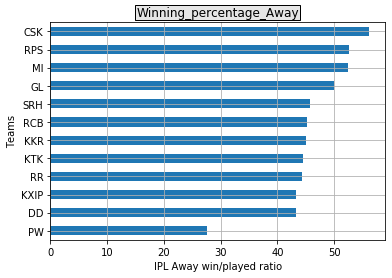

In [22]:

Teams={'RCB':'Bangalore','CSK':'Chennai','SRH':'Hyderabad','MI':'Mumbai','KKR':'Kolkata','KXIP':'Chandigarh','DD':'Delhi','RR':'Jaipur','GL':'Rajkot','PW':'Pune','RPS':'Pune','KTK':'Kochi'}

data_final={}

for i,(j,k) in enumerate(Teams.items()):
    #print(i,j,k)
    data_final[j]=(data1[(data1.city!=k) &((data1.team1==j) | (data1.team2==j))].groupby('winner')['winner'].count()[j])/(data1[(data1.city!=k) &((data1.team1==j) | (data1.team2==j))]['winner'].count())*100

data_final=pd.Series(data_final)
data_final.sort_values().plot(kind='barh',grid=True)
plt.xlabel('IPL Away win/played ratio')
plt.ylabel('Teams')
plt.title('Winning_percentage_Away',bbox={'facecolor':'0.9', 'pad':1.05})




winning_percentage_away=data_final


In [23]:
data1.head()

,date,city,season,team1,team2,toss_winner,toss_decision,winner,win_by_runs,win_by_wickets,dl_applied,overs,player_of_match,venue,first_bat_team,first_bowl_team,first_bat_score,second_bat_score
0,2008-04-18,Bangalore,2008,RCB,KKR,RCB,field,KKR,140.0,NaN,No,20,BB McCullum,M Chinnaswamy Stadium,KKR,RCB,222.0,82.0
1,2008-04-19,Chandigarh,2008,KXIP,CSK,CSK,bat,CSK,33.0,NaN,No,20,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",CSK,KXIP,240.0,207.0
2,2008-04-19,Delhi,2008,DD,RR,RR,bat,DD,NaN,9.0,No,20,MF Maharoof,Feroz Shah Kotla,RR,DD,129.0,132.0
3,2008-04-20,Kolkata,2008,KKR,SRH,SRH,bat,KKR,NaN,5.0,No,20,DJ Hussey,Eden Gardens,SRH,KKR,110.0,112.0
4,2008-04-20,Mumbai,2008,MI,RCB,MI,bat,RCB,NaN,5.0,No,20,MV Boucher,Wankhede Stadium,MI,RCB,165.0,166.0


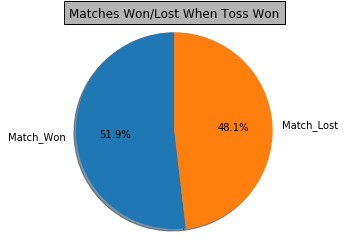

In [24]:
Toss={}

Toss['Won']=data1[data1.toss_winner==data1.winner].groupby('winner')['winner'].count().sort_values(ascending=True).sum()/data1.count()['winner']
Toss['Lost']=data1[data1.toss_winner!=data1.winner].groupby('winner')['winner'].count().sort_values(ascending=True).sum()/data1.count()['winner']

Toss=pd.Series(Toss)
labels=['Match_Won', 'Match_Lost']
       
        
fig1, ax1 = plt.subplots()
ax1.pie(Toss, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Matches Won/Lost When Toss Won", bbox={'facecolor':'0.7', 'pad':5})
plt.show()






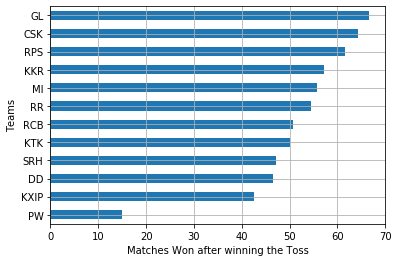

In [25]:


Toss_Won_Per_Team=data1[data1.toss_winner==data1.winner].groupby('winner')['team1'].count().sort_values()
#print(Toss_Won_Per_Team)
#print(data1.toss_winner.value_counts())


Matches_Won_Toss_Won_Per=Toss_Won_Per_Team/data1.toss_winner.value_counts()

(Matches_Won_Toss_Won_Per*100).sort_values().plot(kind='barh',grid=True)

plt.xlabel('Matches Won after winning the Toss')
plt.ylabel('Teams')

Toss_Winner_Per=(Matches_Won_Toss_Won_Per*100)

Text(0, 0.5, 'Succesful Teams Toss_Decisions Percentage')

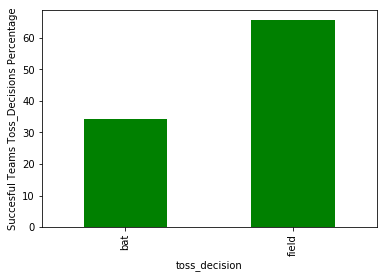

In [80]:
A=data1[(data1.toss_winner==data1.winner)].groupby('toss_decision').count()['winner']
B=data1[(data1.toss_winner==data1.winner)].groupby('toss_decision').count().sum()['winner']
((A/B)*100).plot(kind='bar',color='green')
#data1[(data1.toss_winner!=data1.winner)].groupby('toss_decision').count()['winner']

plt.ylabel('Succesful Teams Toss_Decisions Percentage')

357

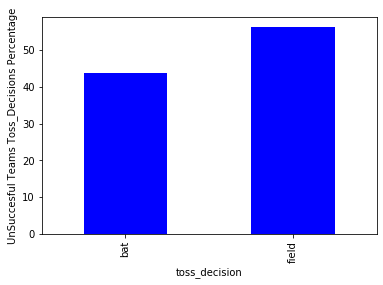

In [79]:
A=data1[(data1.toss_winner!=data1.winner)].groupby('toss_decision').count()['winner']
B=data1[(data1.toss_winner!=data1.winner)].groupby('toss_decision').count().sum()['winner']
((A/B)*100).plot(kind='bar',color='blue')
#data1[(data1.toss_winner!=data1.winner)].groupby('toss_decision').count()['winner']

plt.ylabel('UnSuccesful Teams Toss_Decisions Percentage')
B

count    132.000000
mean     170.484848
std       23.716353
min      116.000000
25%      156.750000
50%      170.000000
75%      184.000000
max      246.000000
Name: first_bat_score, dtype: float64
count    253.000000
mean     152.110672
std       29.606741
min       67.000000
25%      135.000000
50%      157.000000
75%      175.000000
max      214.000000
Name: first_bat_score, dtype: float64
count    156.000000
mean     147.833333
std       24.980465
min       80.000000
25%      131.750000
50%      147.500000
75%      163.250000
max      205.000000
Name: first_bat_score, dtype: float64
count    201.000000
mean     178.194030
std       28.477661
min      106.000000
25%      161.000000
50%      176.000000
75%      197.000000
max      263.000000
Name: first_bat_score, dtype: float64


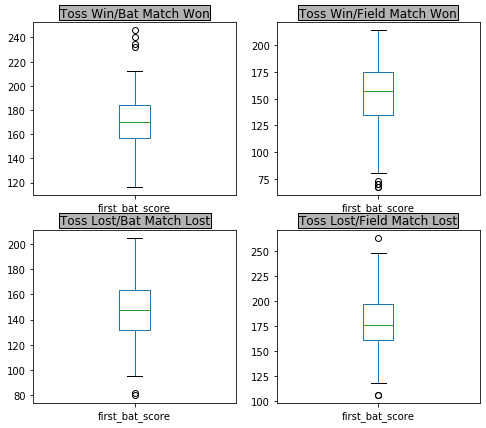

In [24]:


plt.subplot(2,2,1)
print(data1[((data1.toss_winner==data1.winner) & (data1.toss_decision=='bat'))]['first_bat_score'].describe())
data1[((data1.toss_winner==data1.winner) & (data1.toss_decision=='bat'))]['first_bat_score'].plot(kind='box',figsize=(8,7))
plt.title("Toss Win/Bat Match Won", bbox={'facecolor':'0.7', 'pad':1})

plt.subplot(2,2,2)
print(data1[((data1.toss_winner==data1.winner) & (data1.toss_decision=='field'))]['first_bat_score'].describe())
data1[((data1.toss_winner==data1.winner) &(data1.toss_decision=='field'))]['first_bat_score'].plot(kind='box',figsize=(8,7))
plt.title("Toss Win/Field Match Won", bbox={'facecolor':'0.7', 'pad':1})

plt.subplot(2,2,3)
print(data1[((data1.toss_winner!=data1.winner) & (data1.toss_decision=='bat'))]['first_bat_score'].describe())
plt.title("Toss Lost/Bat Match Lost", bbox={'facecolor':'0.7', 'pad':1})
data1[((data1.toss_winner!=data1.winner) & (data1.toss_decision=='bat'))]['first_bat_score'].plot(kind='box',figsize=(8,7))

plt.subplot(2,2,4)
print(data1[((data1.toss_winner!=data1.winner) & (data1.toss_decision=='field'))]['first_bat_score'].describe())
plt.title("Toss Lost/Field Match Lost", bbox={'facecolor':'0.7', 'pad':1})
data1[((data1.toss_winner!=data1.winner) &(data1.toss_decision=='field'))]['first_bat_score'].plot(kind='box',figsize=(8,7))


plt.show()



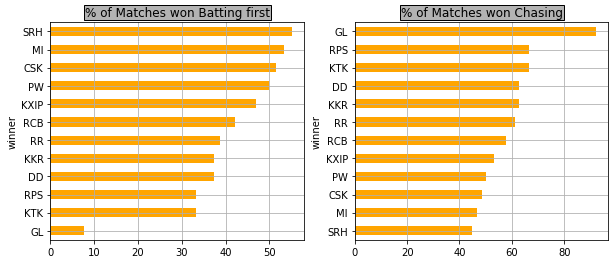

In [99]:
plt.subplot(1,2,1)

Tot_P_team=data1.winner.value_counts()
k=(data1[(data1.first_bat_team==data1.winner)].groupby('winner').count()['team1'].sort_values())/(data1.groupby('winner').count()['team1'])

(k*100).sort_values().plot(kind='barh',figsize=(10,4),grid=True,color='orange',stacked=True)
data1.groupby('winner').count()['team1']
plt.title("% of Matches won Batting first", bbox={'facecolor':'0.7', 'pad':1})
plt.subplot(1,2,2)
l=data1[(data1.first_bowl_team==data1.winner)].groupby('winner').count()['team1'].sort_values()/(data1.groupby('winner').count()['team1'])
(l*100).sort_values().plot(kind='barh',figsize=(10,4),grid=True,color='orange')
plt.title("% of Matches won Chasing", bbox={'facecolor':'0.7', 'pad':1})
#data1[((data1.toss_winner=='Chennai Super Kings') & (data1.toss_decision=='bat'))]['first_bat_score']
#plt.title("Toss Win/Bat Match Won", bbox={'facecolor':'0.7', 'pad':1})
#print(Tot_P_team)
plt.show()

matches_won_batting_first_per=k*100
matches_won_chasing_per=l*100

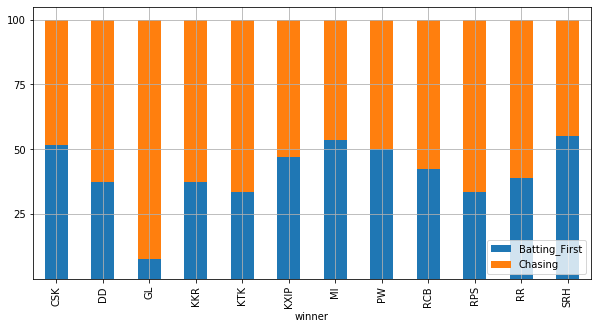

In [115]:
kl=pd.DataFrame({"Batting_First":k,"Chasing":l}).multiply(100)
kl.plot(kind='bar',stacked=True,figsize=(10,5),grid=True,yticks=[25,50,75,100])
plt.legend(loc='lower right')



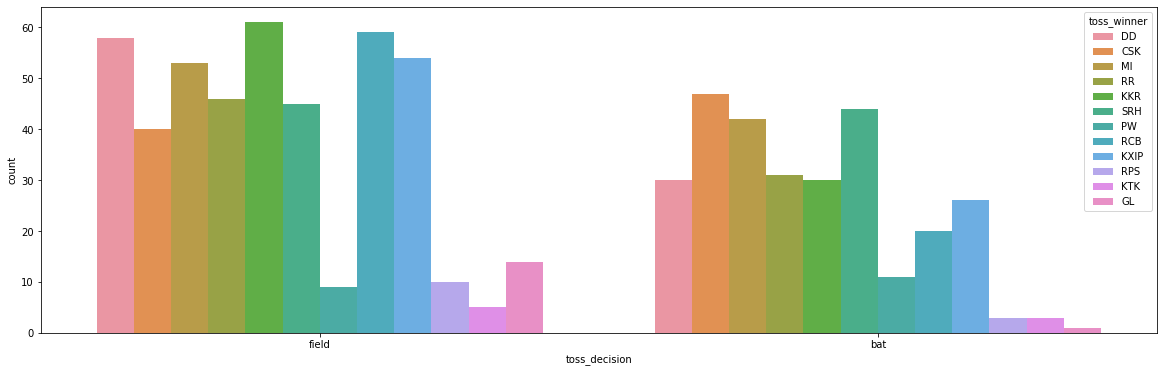

In [26]:
#plt.subplot(2,1,1)
#data1[(data1.toss_decision=='bat')].groupby('winner').count()['team1'].sort_values().plot(kind='barh',figsize=(8,8),grid=True)
plt.figure(figsize=(20,6))
sns.countplot(x='toss_decision',hue='toss_winner',data=data1.sort_values('team1'))
#print(data1.groupby(['toss_decision']).count()['first_bat_team'] )
#plt.title("Total Matches won Batting first", bbox={'facecolor':'0.7', 'pad':1})
#plt.subplot(2,1,2)
#data1[(data1.toss_decision=='field')].groupby('winner').count()['team1'].sort_values().plot(kind='barh',figsize=(8,8),grid=True)
#plt.title("Total Matches won Chasing", bbox={'facecolor':'0.7', 'pad':1})

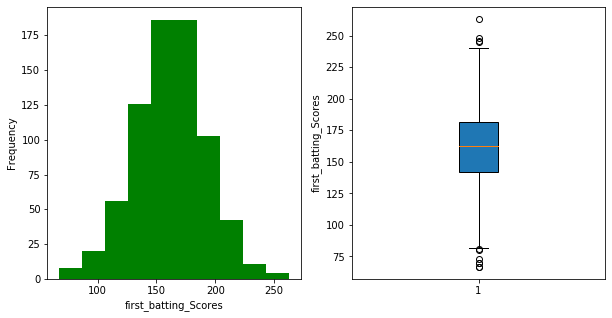

count    742.000000
mean     161.545822
std       30.105705
min       67.000000
25%      142.000000
50%      163.000000
75%      182.000000
max      263.000000
Name: first_bat_score, dtype: float64

In [148]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
data1.first_bat_score.plot(kind='hist',color='green',figsize=(10,5))
plt.xlabel('first_batting_Scores')
plt.subplot(1,2,2)
plt.boxplot(data1.first_bat_score,patch_artist=True)
plt.ylabel('first_batting_Scores')
plt.show()
data1.first_bat_score.describe()


winner
CSK     176.941176
DD      182.642857
GL      172.000000
KKR     172.352941
KTK     144.000000
KXIP    173.526316
MI      175.928571
PW      164.666667
RCB     184.742857
RPS     157.600000
RR      177.206897
SRH     167.416667
Name: first_bat_score, dtype: float64


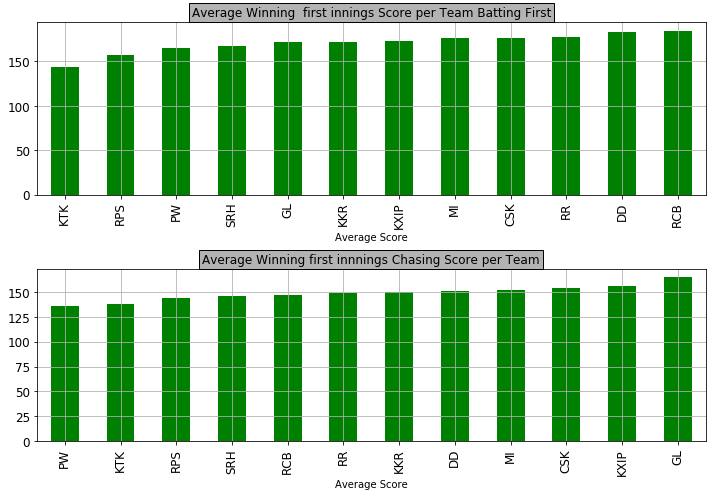

In [238]:
plt.rc('ytick',labelsize=12)
plt.rc('xtick',labelsize=12)

plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
test=data1[(data1.winner==data1.first_bat_team)].groupby(['winner'])['first_bat_score'].agg('mean')
print(test)
test.sort_values().plot(kind='bar',grid=True,figsize=(10,7),color='green')
plt.title("Average Winning  first innings Score per Team Batting First", bbox={'facecolor':'0.7', 'pad':3})
plt.xlabel('Average Score')


plt.subplot(2,1,2)
test=data1[(data1.winner==data1.first_bowl_team)].groupby(['winner'])['first_bat_score'].agg('mean')
#print(test)
test.sort_values().plot(kind='bar',grid=True,figsize=(10,7),color='green')
plt.title("Average Winning first innnings Chasing Score per Team", bbox={'facecolor':'0.7', 'pad':3})
plt.xlabel('Average Score')

plt.tight_layout()
plt.show()

season
2009    150.263158
2011    153.708333
2013    155.894737
2012    157.540541
2008    160.965517
2016    162.600000
2014    163.066667
2010    164.783333
2015    165.298246
2017    165.779661
2019    171.734694
2018    172.466667
Name: first_bat_score, dtype: float64

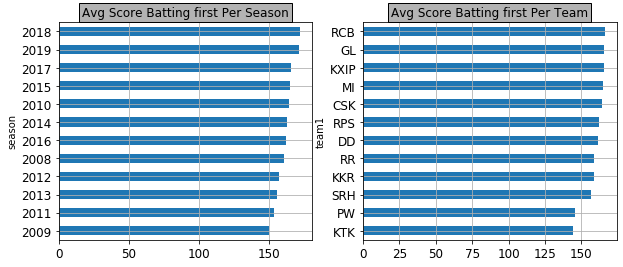

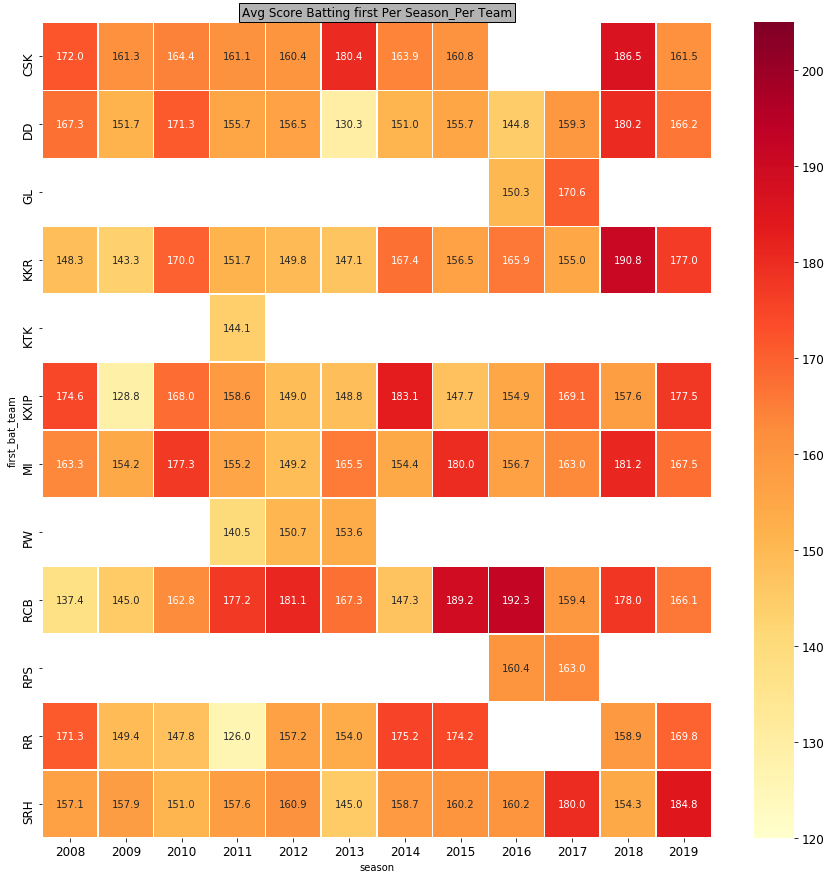

In [236]:
Avg_Per_team_per_season= pd.pivot_table(data1,values=['first_bat_score'],index=['first_bat_team'],columns=['season'],aggfunc='mean',margins=False)
#Avg_Per_team_Per_season

#data1.groupby('first_bat_team')['first_bat_score'].agg('mean')

plt.subplot(1,2,1)
plt.title('Avg Score Batting first Per Season',bbox={'facecolor':'0.7', 'pad':3})
Avg_first_bat_score_per_season=data1.groupby('season')['first_bat_score'].agg('mean').sort_values().plot(kind='barh',grid=True,figsize=(10,4))
#print(Avg_first_bat_score_per_season)
plt.subplot(1,2,2)
plt.title('Avg Score Batting first Per Team',bbox={'facecolor':'0.7', 'pad':3})
Avg_first_bat_score_per_Team=data1.groupby('team1')['first_bat_score'].agg('mean').sort_values().plot(kind='barh',grid=True,figsize=(10,4))
#print(Avg_first_bat_score_per_Team)

plt.figure(figsize=(15,15))
sns.heatmap(Avg_Per_team_per_season['first_bat_score'],fmt='0.1f',linewidths=.5,annot=True,vmin=120,vmax=205,cmap='YlOrRd')
plt.title('Avg Score Batting first Per Season_Per Team',bbox={'facecolor':'0.7', 'pad':3})



CSK     64.367816
DD      46.590909
GL      66.666667
KKR     57.142857
KTK     50.000000
KXIP    42.500000
MI      55.789474
PW      15.000000
RCB     50.632911
RPS     61.538462
RR      54.545455
SRH     47.191011
Name: team1, dtype: float64
CSK     49.425287
DD      38.636364
GL      20.000000
KKR     42.857143
KTK     25.000000
KXIP    58.750000
MI      54.736842
PW      45.000000
RCB     54.430380
RPS     53.846154
RR      42.857143
SRH     50.561798
Name: team1, dtype: float64


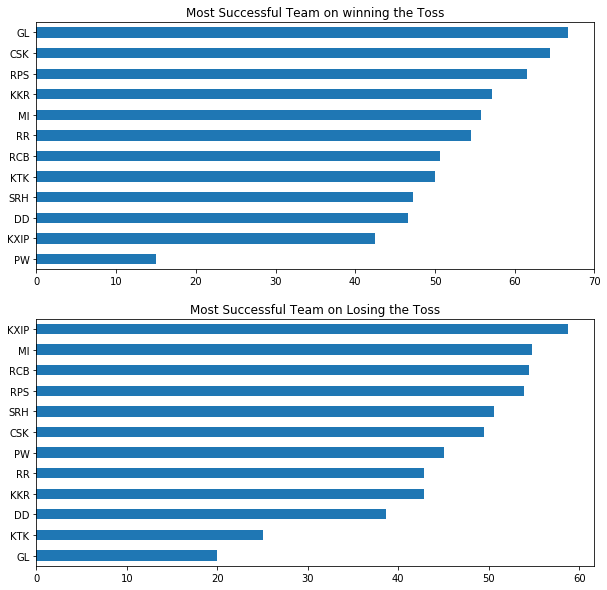

In [153]:
data1.head()
#A=data1.groupby(['toss_winner','city','winner']).count()['team1'].sort_values(ascending=False)
#print(A)
#B=data1.groupby(['toss_winner','city']).count()['team1'].sort_values(ascending=False)
#print(B)
#(A/B)[300:359]

M=data1[data1.toss_winner==data1.winner].groupby('winner').count()['team1'].sort_values()
N=data1.groupby('toss_winner').count()['team1'].sort_values()
#print(M)

#Most Succesful Team on Winning the Toss
plt.subplot(2,1,1)
X=M/N
print(X*100)
(X*100).sort_values().plot(kind='barh',figsize=(10,10))
plt.title('Most Successful Team on winning the Toss')

plt.subplot(2,1,2)
O=data1[data1.toss_winner!=data1.winner].groupby('winner').count()['team1'].sort_values()
Y=O/N
print(Y*100)
(Y*100).sort_values().plot(kind='barh',figsize=(10,10))
plt.title('Most Successful Team on Losing the Toss')

Toss_loser_Per=Y*100



In [154]:
deliveries=pd.read_csv('deliveries.csv')
deliveries.info()
deliveries.replace('Rising Pune Supergiant','Rising Pune Supergiants',inplace=True)
deliveries.replace('Delhi Capitals','Delhi Daredevils',inplace=True)
deliveries.replace('Deccan Chargers','Sunrisers Hyderabad',inplace=True)
deliveries.replace(to_replace =['Delhi Daredevils', 'Sunrisers Hyderabad','Royal Challengers Bangalore','Chennai Super Kings','Mumbai Indians','Kolkata Knight Riders','Kings XI Punjab','Rajasthan Royals','Rising Pune Supergiants','Gujarat Lions','Pune Warriors','Kochi Tuskers Kerala']
                            ,value =['DD','SRH','RCB','CSK','MI','KKR','KXIP','RR','RPS','GL','PW','KTK'],inplace=True) 

print(deliveries.groupby('batsman').count()['batsman_runs'].sort_values(ascending=False)[:10])
#print(deliveries.groupby('fielder').count()['batsman'].sort_values(ascending=False)[:10])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179078 entries, 0 to 179077
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   match_id          179078 non-null  int64 
 1   inning            179078 non-null  int64 
 2   batting_team      179078 non-null  object
 3   bowling_team      179078 non-null  object
 4   over              179078 non-null  int64 
 5   ball              179078 non-null  int64 
 6   batsman           179078 non-null  object
 7   non_striker       179078 non-null  object
 8   bowler            179078 non-null  object
 9   is_super_over     179078 non-null  int64 
 10  wide_runs         179078 non-null  int64 
 11  bye_runs          179078 non-null  int64 
 12  legbye_runs       179078 non-null  int64 
 13  noball_runs       179078 non-null  int64 
 14  penalty_runs      179078 non-null  int64 
 15  batsman_runs      179078 non-null  int64 
 16  extra_runs        179078 non-null  int

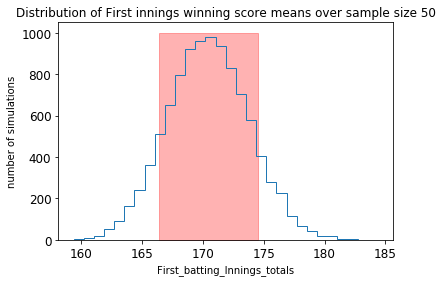

In [234]:
#Using frequentist Inference to find the mean first_innings_Batting_Winning score

first_batting_score=data1[(data1.winner==data1.toss_winner) & (data1.toss_decision=='bat')]['first_bat_score']
first_bat_mean_distribution=[np.mean(np.random.choice(first_batting_score,50)) for i in range(10000)]
_ = plt.hist(first_bat_mean_distribution,histtype='step',bins=30)
_ = plt.xlabel('First_batting_Innings_totals')
_ = plt.ylabel('number of simulations')
_ = plt.title('Distribution of First innings winning score means over sample size 50')

critical_value = norm.ppf(0.975)
# Calculating Standard error
standard_error = (first_batting_score.std()) / np.sqrt(len(first_batting_score))

# Calculating margin of error using z critical value
ME_95 = critical_value * standard_error

Confid_Inter_95=(first_batting_score.mean()-ME_95,first_batting_score.mean()+ME_95)


plt.fill_betweenx([0, 1000], Confid_Inter_95[0], Confid_Inter_95[1], color='r', alpha=0.3)  # Mark between 0 and the highest bar in the histogram
plt.show()


In [235]:
Confid_Inter_95

(166.43900536980695, 174.53069159989005)

In [157]:
#Using Bootstrap Inference to find the mean first_innings_Batting_Winning score
np.random.seed(47)
N_rep = 10000


def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

sample_charges=draw_bs_reps(first_batting_score,np.mean,N_rep)
#finding Confidence Interval of Sample charges 
Confid_Int_95=np.percentile(sample_charges,[2.5,97.5])
Confid_Int_95


array([166.55284091, 174.58333333])

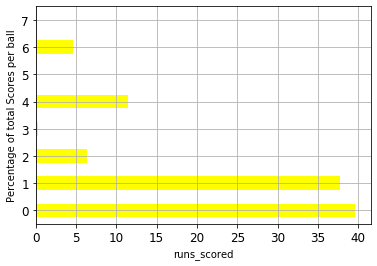

In [245]:
Total_Deliveries_Percentage_of_runs_scored=(deliveries.groupby(['batsman_runs']).count()['penalty_runs']/deliveries.groupby(['batsman_runs']).count()['penalty_runs'].sum())*100

Total_Deliveries_Percentage_of_runs_scored.plot(kind='barh',grid=True,color='yellow')


#sns.countplot(x='batsman_runs',data=deliveries)
#Total_Deliveries_Percentage_of_runs_scored.plot(kind='bar')
plt.xlabel('runs_scored')
plt.ylabel('Percentage of total Scores per ball')

#ax.annotate('local max', xy=(3, 1),  xycoords='data',xytext=(0.8, 0.95), textcoords='axes fraction',arrowprops=dict(facecolor='black', shrink=0.05),horizontalalignment='right', verticalalignment='top',)

plt.show()
#As per bellow, Approx 40% of the Total balls bowled uptill now are Dot balls.

#Only Aprrox 16% of the Total balls have been hit for a Boundary(6+4) 
#Every 6th Ball is hit for a Boundary


batting_team
MI      12.898256
RCB     12.226035
KXIP    12.022968
KKR     11.777887
SRH     11.672852
DD      11.511799
CSK     11.084658
RR       9.509138
PW       2.524333
GL       2.153211
RPS      1.838107
KTK      0.780758
Name: bowling_team, dtype: float64


Text(0.5, 1.0, 'Percentage of Boundaries hit Per team')

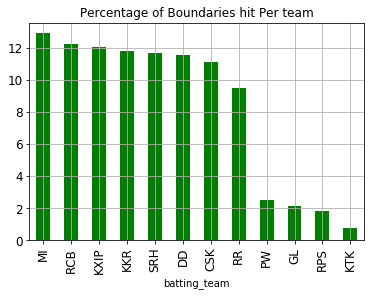

In [244]:
#Percentage of Boundaries_Hit

df=deliveries[(deliveries['batsman_runs']==6) | (deliveries['batsman_runs']==4)]
df_sum=df.count()
#print(df_sum)
Bound_Percentage=((df.groupby('batting_team').count()['bowling_team'].sort_values(ascending=False)/df.groupby('batting_team').count()['bowling_team'].sort_values().sum())*100)#.plot(kind='barh',grid=True)

Bound_Percentage.plot(kind='bar',grid=True,color='green')
print(Bound_Percentage.sort_values(ascending=False))
plt.title("Percentage of Boundaries hit Per team")
#plt.xlabel('Total no of Boundaries Hit by each over the IPL')


-0.29423320887465226


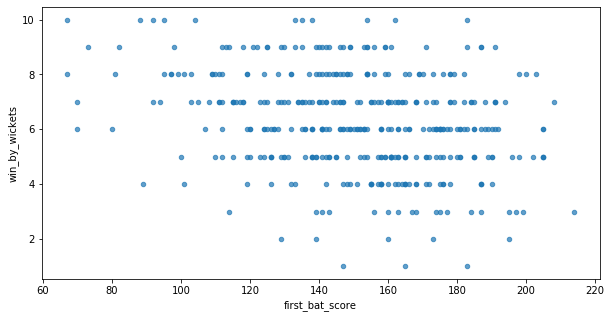

In [36]:
#deliveries.info()
#data1.info()
'''
Toss
Venue(Home/Away)
First_innings_score


'''

data1.plot(kind='scatter',x='first_bat_score',y='win_by_wickets',figsize=(10,5),alpha=0.7)
print(data1['first_bat_score'].corr(data1['win_by_wickets']))


#Negative Correlation of -029 Shows as the First innings score increases, team lose more wickets and win by_wickets decreases.








0.41622082102453495


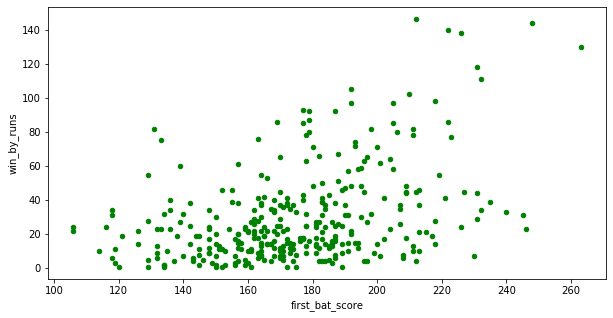

In [37]:
data1.plot(kind='scatter',x='first_bat_score',y='win_by_runs',figsize=(10,5),color='green')


print(data1['first_bat_score'].corr(data1['win_by_runs']))

#Positive Correlation of 0.41 shows as the Team score higher first innings scores the margin(win_by_runs) of winning also increases
# Print the result



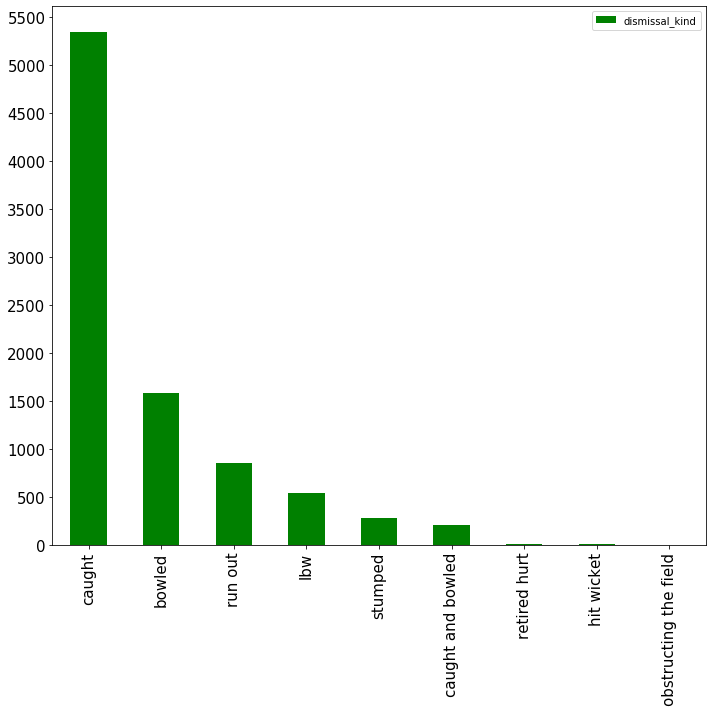

In [202]:


deliveries['dismissal_kind'].value_counts().plot(kind='bar',figsize=(10,10),yticks=np.arange(0,6000,500),color='green')
plt.legend()
plt.tight_layout()
#deliveries.groupby(['dismissal_kind','player_dismissed']).count()['inning'].sort_values(ascending=False)

    Team  Total_Boundaries_Scored  Total_Matches_Won
7     PW                 3.600955          26.666667
4    KTK                 3.350190          42.857143
2     GL                 4.346607          43.333333
1     DD                 4.290892          43.604651
5   KXIP                 4.662940          46.551724
8    RCB                 5.414196          47.159091
11   SRH                 4.252119          48.333333
9    RPS                 4.511494          50.000000
3    KKR                 4.458721          51.704545
10    RR                 3.938237          52.083333
6     MI                 4.845484          57.377049
0    CSK                 4.923591          61.875000
0.5810993621700725


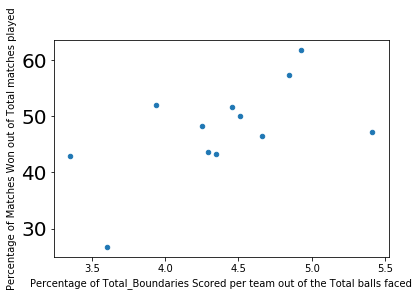

In [181]:

df=deliveries[(deliveries['batsman_runs']==6)]
total_balls_faced=deliveries.groupby('batting_team').count()['batsman']
#print(total_balls_faced)
df1=df.groupby('batting_team').count()['inning'].sort_values()/total_balls_faced

total_matches_played=data1.groupby('team1').count()['team2'].sort_values().add(data1.groupby('team2').count()['team1'].sort_values())
df2=data1.groupby(['winner']).count()['team1'].sort_values()/total_matches_played
#print(total_matches_played)

kd=pd.concat([df1*100,df2*100],axis=1).reset_index().dropna()
kd.columns=['Team','Total_Boundaries_Scored','Total_Matches_Won']
kd.set_index('Team')
print(kd.sort_values(by=['Total_Matches_Won']))



kd.plot(kind='scatter',x='Total_Boundaries_Scored',y='Total_Matches_Won')
r=kd['Total_Boundaries_Scored'].corr(kd['Total_Matches_Won'])

print(r)
plt.xlabel('Percentage of Total_Boundaries Scored per team out of the Total balls faced')
plt.ylabel('Percentage of Matches Won out of Total matches played')
#50% - Moderate Correlation of Most Boundaries  hitting Team hit wins most no of matches
plt.show()

In [40]:
data1.head()

,date,city,season,team1,team2,toss_winner,toss_decision,winner,win_by_runs,win_by_wickets,dl_applied,overs,player_of_match,venue,first_bat_team,first_bowl_team,first_bat_score,second_bat_score
0,2008-04-18,Bangalore,2008,RCB,KKR,RCB,field,KKR,140.0,NaN,No,20,BB McCullum,M Chinnaswamy Stadium,KKR,RCB,222.0,82.0
1,2008-04-19,Chandigarh,2008,KXIP,CSK,CSK,bat,CSK,33.0,NaN,No,20,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",CSK,KXIP,240.0,207.0
2,2008-04-19,Delhi,2008,DD,RR,RR,bat,DD,NaN,9.0,No,20,MF Maharoof,Feroz Shah Kotla,RR,DD,129.0,132.0
3,2008-04-20,Kolkata,2008,KKR,SRH,SRH,bat,KKR,NaN,5.0,No,20,DJ Hussey,Eden Gardens,SRH,KKR,110.0,112.0
4,2008-04-20,Mumbai,2008,MI,RCB,MI,bat,RCB,NaN,5.0,No,20,MV Boucher,Wankhede Stadium,MI,RCB,165.0,166.0


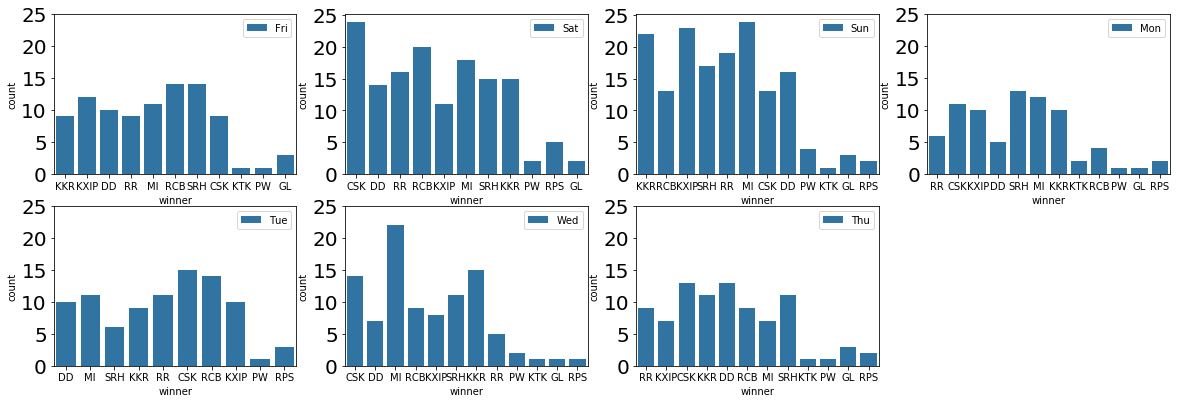

In [182]:
data1['weekday']=data1['date'].dt.dayofweek
weekday={0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
data1['weekday']=data1['weekday'].map(weekday)
data1.tail()

plt.figure(figsize=(20,10))
x=0
for team in data1.weekday.unique():
    x=x+1
    plt.subplot(3,4,x)
    sns.countplot(x='winner',hue='weekday',data=data1[data1.weekday==team])
    plt.yticks(np.arange(0,30,5))
    plt.legend(loc='upper right')
#plt.yticks(np.arange(0,25,4))
plt.show()


_#The Bar plot shows for every match held over the weekend shows that Each team have a higher chance of winning if the match is held on a weekend. It may be also be the case that more matches are held on Fri and sat. Let us check

In [42]:
#Gives the Info If a Match i won by the Home Team
Team=['Bangalore','Chennai','Hyderabad','Mumbai','Kolkata','Chandigarh','Delhi','Jaipur','Pune']
data1['Home_Winner']=(data1.winner==data1.team1)



In [43]:
#Rank = 1*Overall_Percentage + 0.75*winning_percentage_home +1.25*winning_percentage_away + 1*Toss_Winner_Per+ 1.5*Toss_loser_Per + 1*matches_won_batting_first_per + 1*matches_won_chasing_per

In [44]:
Rank={}
for i in ['CSK','MI','SRH','DD','KKR','KXIP','RR','RCB','GL','PW','RPS','KTK']:
    Rank[i]=1*Overall_Percentage[i] + 0.75*winning_percentage_home[i] +1.25*winning_percentage_away[i] + 1*Toss_Winner_Per[i]+ 1.5*Toss_loser_Per[i] + 1*matches_won_batting_first_per[i] + 1*matches_won_chasing_per[i]
    #print(Rank[i])
    
Rank_Sr=pd.Series(Rank)

Rank_Sr=Rank_Sr/500
Rank_Sr.sort_values(axis=0,ascending=False)


CSK     0.850329
MI      0.817237
RPS     0.784376
RR      0.754781
KKR     0.750228
RCB     0.746856
KXIP    0.743242
SRH     0.736980
DD      0.670650
GL      0.650000
KTK     0.631825
PW      0.524799
dtype: float64

In [45]:
data1['Rank_Team1']=0
data1['Rank_Team2']=0

Conditions=[data1.team1=='CSK',data1.team1=='MI',data1.team1=='SRH',data1.team1=='DD',data1.team1=='KKR',data1.team1=='KXIP',\
            data1.team1=='RR',data1.team1=='RCB',data1.team1=='GL',data1.team1=='PW',data1.team1=='RPS',data1.team1=='KTK']
values=list(Rank_Sr.values)

data1['Rank_Team1']=np.where(data1['team1'].notnull(),np.select(Conditions,values,default=0),data1['Rank_Team1'])


Conditions_2=[data1.team2=='CSK',data1.team2=='MI',data1.team2=='SRH',data1.team2=='DD',data1.team2=='KKR',data1.team2=='KXIP',\
            data1.team2=='RR',data1.team2=='RCB',data1.team2=='GL',data1.team2=='PW',data1.team2=='RPS',data1.team2=='KTK']

data1['Rank_Team2']=np.where(data1['team2'].notnull(),np.select(Conditions_2,values,default=0),data1['Rank_Team2'])
data1.head()

,date,city,season,team1,team2,toss_winner,toss_decision,winner,win_by_runs,win_by_wickets,...,player_of_match,venue,first_bat_team,first_bowl_team,first_bat_score,second_bat_score,weekday,Home_Winner,Rank_Team1,Rank_Team2
0,2008-04-18,Bangalore,2008,RCB,KKR,RCB,field,KKR,140.0,NaN,...,BB McCullum,M Chinnaswamy Stadium,KKR,RCB,222.0,82.0,Fri,False,0.746856,0.750228
1,2008-04-19,Chandigarh,2008,KXIP,CSK,CSK,bat,CSK,33.0,NaN,...,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",CSK,KXIP,240.0,207.0,Sat,False,0.743242,0.850329
2,2008-04-19,Delhi,2008,DD,RR,RR,bat,DD,NaN,9.0,...,MF Maharoof,Feroz Shah Kotla,RR,DD,129.0,132.0,Sat,True,0.670650,0.754781
3,2008-04-20,Kolkata,2008,KKR,SRH,SRH,bat,KKR,NaN,5.0,...,DJ Hussey,Eden Gardens,SRH,KKR,110.0,112.0,Sun,True,0.750228,0.736980
4,2008-04-20,Mumbai,2008,MI,RCB,MI,bat,RCB,NaN,5.0,...,MV Boucher,Wankhede Stadium,MI,RCB,165.0,166.0,Sun,False,0.817237,0.746856


### Machine Learning

We will be using Decision Tree,SVM and Random forest classfier and tune them on the basis of hypertuning parameters.

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#creating labelEncoder

le = LabelEncoder()
# Converting string labels into numbers.

data1['City_labels']=le.fit_transform(data1['city'])
#print(City_encoded)
data1['toss_decision_labels']=le.fit_transform(data1['toss_decision'])

Team={'CSK':0,'MI':1,'SRH':2,'DD':3,'KKR':4,'KXIP':5,'RR':6,'RCB':7,'GL':8,'PW':9,'RPS':10,'KTK':11}

ML_data1=data1.replace(Team)
#print(ML_data1)






 






In [47]:
ML_data1.head()


,date,city,season,team1,team2,toss_winner,toss_decision,winner,win_by_runs,win_by_wickets,...,first_bat_team,first_bowl_team,first_bat_score,second_bat_score,weekday,Home_Winner,Rank_Team1,Rank_Team2,City_labels,toss_decision_labels
0,2008-04-18,Bangalore,2008,7,4,7,field,4,140.0,NaN,...,4,7,222.0,82.0,Fri,False,0.746856,0.750228,2,1
1,2008-04-19,Chandigarh,2008,5,0,0,bat,0,33.0,NaN,...,0,5,240.0,207.0,Sat,False,0.743242,0.850329,6,0
2,2008-04-19,Delhi,2008,3,6,6,bat,3,NaN,9.0,...,6,3,129.0,132.0,Sat,True,0.670650,0.754781,9,0
3,2008-04-20,Kolkata,2008,4,2,2,bat,4,NaN,5.0,...,2,4,110.0,112.0,Sun,True,0.750228,0.736980,20,0
4,2008-04-20,Mumbai,2008,1,7,1,bat,7,NaN,5.0,...,1,7,165.0,166.0,Sun,False,0.817237,0.746856,21,0


In [50]:


#data1[(data1.team2=='MI') & (data1.city=='Mumbai')]['team1'].replace(team1)
conditions_Home_team=[(ML_data1.city=='Chennai') &(ML_data1.team1==0),(ML_data1.city=='Mumbai') &(ML_data1.team1==1),\
           (ML_data1.city=='Hyderabad') &(ML_data1.team1==2),(ML_data1.city=='Delhi') &(ML_data1.team1==3),\
           (ML_data1.city=='Kolkata') &(ML_data1.team1==4),(ML_data1.city=='Chandigarh') &(ML_data1.team1==5),\
           (ML_data1.city=='Jaipur') &(ML_data1.team1==6),(ML_data1.city=='Bangalore') &(ML_data1.team1==7),\
           (ML_data1.city=='Rajkot') &(ML_data1.team1==8),(ML_data1.city=='Pune') &(ML_data1.team1==9),\
           (ML_data1.city=='Pune') &(ML_data1.team1==10),(ML_data1.city=='Kochi') &(ML_data1.team1==11),\
           (ML_data1.city=='Chennai') &(ML_data1.team2==0),(ML_data1.city=='Mumbai') &(ML_data1.team2==1),\
           (ML_data1.city=='Hyderabad') &(ML_data1.team2==2),(ML_data1.city=='Delhi') &(ML_data1.team2==3),\
           (ML_data1.city=='Kolkata') &(ML_data1.team2==4),(ML_data1.city=='Chandigarh') &(ML_data1.team2==5),\
           (ML_data1.city=='Jaipur') &(ML_data1.team2==6),(ML_data1.city=='Bangalore') &(ML_data1.team2==7),\
           (ML_data1.city=='Rajkot') &(ML_data1.team2==8),(ML_data1.city=='Pune') &(ML_data1.team2==9),\
           (ML_data1.city=='Pune') &(ML_data1.team2==10),(ML_data1.city=='Kochi') &(ML_data1.team2==11)]



values=[0,1,2,3,4,5,6,7,8,9,10,11,0,1,2,3,4,5,6,7,8,9,10,11]

ML_data1['Home_Team']=12
ML_data1['Home_Team']=np.where(ML_data1['Home_Team'].notnull(),np.select(conditions_Home_team,values,default=12),ML_data1['Home_Team'])


ML_data1.head()

ML_data1['Away_Team']=12

#len(ML_data1[ML_data1.Home_Team==ML_data1.team1])
#len(ML_data1[ML_data1.Home_Team==ML_data1.team2])

put=ML_data1[(ML_data1.Home_Team!=1000) &(ML_data1.team1==ML_data1.Home_Team)]['Home_Team'].index.values

for i in range(len(put)):
    ML_data1.Away_Team[put[i]]=ML_data1.team2[put[i]]

put=ML_data1[(ML_data1.Home_Team!=1000) &(ML_data1.team2==ML_data1.Home_Team)]['Home_Team'].index.values

for i in range(len(put)):
    ML_data1.Away_Team[put[i]]=ML_data1.team1[put[i]]  

ML_data1.head()

ML_data1[(ML_data1.Away_Team==12) & (ML_data1.Home_Team==12)]



C:\Users\Devil\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Devil\anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,city,season,team1,team2,toss_winner,toss_decision,winner,win_by_runs,win_by_wickets,...,first_bat_score,second_bat_score,weekday,Home_Winner,Rank_Team1,Rank_Team2,City_labels,toss_decision_labels,Home_Team,Away_Team
55,2008-05-30,Mumbai,2008,3,6,3,field,6,105.0,NaN,...,192.0,87.0,Fri,False,0.670650,0.754781,21,1,12,12
56,2008-05-31,Mumbai,2008,0,5,5,bat,0,NaN,9.0,...,112.0,116.0,Sat,True,0.850329,0.743242,21,0,12,12
57,2008-06-01,Mumbai,2008,0,6,6,field,6,NaN,3.0,...,163.0,164.0,Sun,False,0.850329,0.754781,21,1,12,12
58,2009-04-18,Cape Town,2009,7,6,7,bat,7,75.0,NaN,...,133.0,58.0,Sat,True,0.746856,0.754781,4,0,12,12
59,2009-04-18,Cape Town,2009,0,1,0,field,1,19.0,NaN,...,165.0,146.0,Sat,False,0.850329,0.817237,4,1,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,2018-05-13,Pune,2018,0,2,0,field,0,NaN,8.0,...,179.0,180.0,Sun,True,0.850329,0.736980,24,1,12,12
680,2018-05-14,Indore,2018,5,7,7,field,7,NaN,10.0,...,88.0,92.0,Mon,False,0.743242,0.746856,14,1,12,12
688,2018-05-20,Pune,2018,0,5,0,field,0,NaN,5.0,...,153.0,159.0,Sun,True,0.850329,0.743242,24,1,12,12
689,2018-05-22,Mumbai,2018,2,0,0,field,0,NaN,2.0,...,139.0,140.0,Tue,False,0.736980,0.850329,21,1,12,12


In [51]:
ML_data1['Winner_A']=0
ML_data1['Winner_B']=0
ML_data1['Winner_A']=ML_data1[ML_data1.Rank_Team1>ML_data1.Rank_Team2]['team1']
ML_data1['Winner_B']=ML_data1[ML_data1.Rank_Team1<ML_data1.Rank_Team2]['team2']

ML_data1['final_Winner']=0
ML_data1['final_Winner']=ML_data1['Winner_A'].add(ML_data1['Winner_B'])

ML_data1[['winner','final_Winner','Winner_A','Winner_B','Rank_Team1','Rank_Team2']]

ML_data1['Winner_A'].fillna(0)
ML_data1['Winner_B'].fillna(0)

ML_data1['final_Winner']=ML_data1['Winner_A'].add(ML_data1['Winner_B'],fill_value=0)
ML_data1['final_Winner']=ML_data1['final_Winner'].astype('int64')
ML_data1[['winner','final_Winner','Winner_A','Winner_B','Rank_Team1','Rank_Team2']]


,winner,final_Winner,Winner_A,Winner_B,Rank_Team1,Rank_Team2
0,4,4,NaN,4.0,0.746856,0.750228
1,0,0,NaN,0.0,0.743242,0.850329
2,3,6,NaN,6.0,0.670650,0.754781
3,4,4,4.0,NaN,0.750228,0.736980
4,7,1,1.0,NaN,0.817237,0.746856
...,...,...,...,...,...,...
737,6,6,6.0,NaN,0.754781,0.736980
738,3,7,NaN,7.0,0.670650,0.746856
739,4,1,NaN,1.0,0.750228,0.817237
740,2,5,NaN,5.0,0.736980,0.743242


              Specs       Score
12     final_Winner  818.479233
9      venue_labels  423.384750
1       City_labels  379.694773
0       toss_winner  374.185095
2             team1  359.702788
11  first_bowl_team  359.042791
3             team2  266.365595
10   first_bat_team  263.210634
7         Home_Team  154.401730
8         Away_Team  139.009872
final_Winner            0.125703
first_bowl_team         0.102513
venue_labels            0.092023
toss_winner             0.090499
team1                   0.075077
Rank_Team1              0.074313
team2                   0.073711
Rank_Team2              0.073144
first_bat_team          0.073041
City_labels             0.071117
Away_Team               0.054461
Home_Team               0.050974
toss_decision_labels    0.043423
dtype: float64


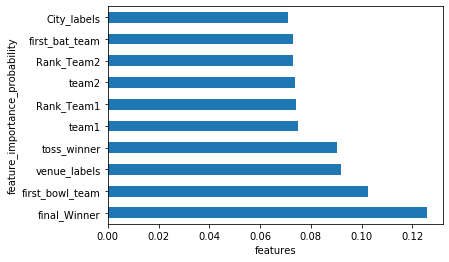

In [52]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

ML_data1['season_labels']=le.fit_transform(data1['season'])
ML_data1['venue_labels']=le.fit_transform(data1['venue'])
#ML_data1['weekday_labels']=le.fit_transform(data1['weekday'])



X1=ML_data1[['toss_winner','City_labels','team1','team2','Rank_Team1','Rank_Team2','toss_decision_labels','Home_Team','Away_Team','venue_labels','first_bat_team','first_bowl_team','final_Winner']]
y1=ML_data1['winner']


#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X1,y1)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X1.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features


from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X1,y1)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X1.columns)
print(feat_importances.sort_values(ascending=False))
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('features')
plt.ylabel('feature_importance_probability')
plt.show()


In [53]:
X=ML_data1[['team1','team2','final_Winner','toss_winner','first_bowl_team','first_bat_team']].values
y=ML_data1['winner'].values

### Decision Tree Classfier

In [54]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,stratify=y)


In [55]:
# With Stratification

from sklearn.metrics import f1_score
#Decision Tree Classifier


dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
print('Training_Score:',dt.score(X_train,y_train)*100)
# Print the accuracy
print('Testing_Score:',dt.score(X_test, y_test)*100)
y_pred=dt.predict(X_test)
print("f1_score:",f1_score(y_pred,y_test,average='weighted')*100)

cv_scores = cross_val_score(dt,X,y,cv=5)
print("Mean_Cross_Validation_Score_Accuracy:",np.mean(cv_scores)*100)




Training_Score: 78.07757166947724
Testing_Score: 53.691275167785236
f1_score: 55.14369004912244
Mean_Cross_Validation_Score_Accuracy: 53.63776528206058


#### Tuning of the Decision Tree using RandomizedSearchCV

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from random import randint
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth':[1,None],
          "max_features": [1,2,3,4,5,6], "min_samples_leaf": [1,2,3,4,5], "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree


# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(dt, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters:",tree_cv.best_params_)
print("Best Accuracy_score is:",tree_cv.best_score_)


Tuned Decision Tree Parameters: {'min_samples_leaf': 5, 'max_features': 6, 'max_depth': None, 'criterion': 'gini'}
Best Accuracy_score is: 0.5404044984581897


### Support Vector Machine(SVM)

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


svc=SVC()
# Fit the classifier to the training data
svc.fit(X_train,y_train)
print('Training_Score:',svc.score(X_train,y_train)*100)
# Print the accuracy
print('Testing_Score:',svc.score(X_test, y_test)*100)
y_pred=svc.predict(X_test)
print("f1_score:",f1_score(y_pred,y_test,average='weighted')*100)

cv_scores = cross_val_score(svc,X,y,cv=5)
print("Mean_Cross_Validation_Score:",np.mean(cv_scores)*100)





Training_Score: 52.61382799325464
Testing_Score: 42.281879194630875
f1_score: 49.75108116678903
Mean_Cross_Validation_Score: 45.555051695991295


###### Since this is a Imbalanced dataset and Muticlass too, SVC comes as a Poor classifier.
anyway, Lets Try to Tune this

#### Tuning the SVM classifier

In [58]:
#Let us the tune C and gamma Using GridSearchCV

parameters = {'C':np.logspace(-2,2,5),
              'gamma':np.logspace(-2, 1, 10)}

G_cv = GridSearchCV(svc,param_grid=parameters,cv=5)
# Fit to the training set
G_cv.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = G_cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Accuracy: {}".format(G_cv.score(X_test, y_test)))
#print(classification_report(y_test, y_pred,zero_division=True))
print("Tuned Model Parameters: {}".format(G_cv.best_params_))

Tuned Model Accuracy: 0.5100671140939598
Tuned Model Parameters: {'C': 100.0, 'gamma': 0.01}


#### Random Forest Classifier

In [59]:
#Create a Random Forest Classifier
rfc=RandomForestClassifier()
# Fit the classifier to the training data
rfc.fit(X_train,y_train)
print('Training_Score:',rfc.score(X_train,y_train)*100)
# Print the accuracy
print('Testing_Score:',rfc.score(X_test, y_test)*100)

y_pred=rfc.predict(X_test)
print("f1_score:",f1_score(y_pred,y_test,average='weighted')*100)
cv_scores = cross_val_score(rfc,X,y,cv=5)
print("Mean_Cross_Validation_Score:",np.mean(cv_scores)*100)





Training_Score: 78.07757166947724
Testing_Score: 57.04697986577181
f1_score: 58.1648416752006
Mean_Cross_Validation_Score: 53.09903863595139


#### Tuning the Random Forest classifier

In [60]:
max_score=0

for i in range(2,50):
    RFC=RandomForestClassifier(n_estimators=i)
    RFC.fit(X_train,y_train)
    score=RFC.score(X_test, y_test)*100
    if score>max_score:
        max_score=score
        n_ests=i
print("\nno of estimators:",n_ests,"\nBest_Score:",max_score)







no of estimators: 22 
Best_Score: 59.73154362416108


In [61]:
#Use the Previously found best estimators to tune Using Randomized_Search_CV

param_dist = {'max_depth':[1,None],
          "max_features": [1,2,3,4,5,6], "min_samples_leaf": [1,2,3,4,5], "criterion": ["gini", "entropy"]}

 

RFC=RandomForestClassifier(n_estimators=n_ests)

# Instantiate the RandomizedSearchCV object: tree_cv
forest_cv = RandomizedSearchCV(RFC, param_dist, cv=5)

forest_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Random_Forest Parameters:",forest_cv.best_params_)
print("Best Accuracy_score is:",forest_cv.best_score_)



Tuned Random_Forest Parameters: {'min_samples_leaf': 4, 'max_features': 1, 'max_depth': None, 'criterion': 'gini'}
Best Accuracy_score is: 0.5620261200798113


### Classification Reports

In [62]:


from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 


print("\nClassification report for Decision tree classifier\n")
print(classification_report(dt.predict(X_test), y_test,zero_division=True))




Classification report for Decision tree classifier

              precision    recall  f1-score   support

           0       0.75      0.58      0.65        26
           1       0.52      0.46      0.49        24
           2       0.78      0.70      0.74        20
           3       0.53      0.50      0.52        16
           4       0.72      0.62      0.67        21
           5       0.25      0.36      0.30        11
           6       0.40      1.00      0.57         6
           7       0.47      0.40      0.43        20
           8       0.33      0.25      0.29         4
           9       0.00      0.00      0.00         1
          10       0.00      1.00      0.00         0
          11       0.00      1.00      0.00         0

    accuracy                           0.54       149
   macro avg       0.40      0.57      0.39       149
weighted avg       0.59      0.54      0.55       149



In [63]:
print("\nClassification Report for Support Vector Machine\n")
print(classification_report(svc.predict(X_test), y_test,zero_division=True))


Classification Report for Support Vector Machine

              precision    recall  f1-score   support

           0       0.95      0.56      0.70        34
           1       0.76      0.42      0.54        38
           2       0.33      0.43      0.38        14
           3       0.00      0.00      0.00         3
           4       0.50      0.39      0.44        23
           5       0.00      1.00      0.00         0
           6       0.27      0.40      0.32        10
           7       0.53      0.33      0.41        27
           8       0.00      1.00      0.00         0
           9       0.00      1.00      0.00         0
          10       0.00      1.00      0.00         0
          11       0.00      1.00      0.00         0

    accuracy                           0.42       149
   macro avg       0.28      0.63      0.23       149
weighted avg       0.63      0.42      0.50       149



In [64]:

print("\nClassification Report for Random Forest Classifier\n")
print(classification_report(rfc.predict(X_test), y_test,zero_division=True))


Classification Report for Random Forest Classifier

              precision    recall  f1-score   support

           0       0.75      0.58      0.65        26
           1       0.48      0.43      0.45        23
           2       0.78      0.64      0.70        22
           3       0.47      0.64      0.54        11
           4       0.67      0.67      0.67        18
           5       0.50      0.57      0.53        14
           6       0.47      0.88      0.61         8
           7       0.65      0.44      0.52        25
           8       0.00      1.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.33      1.00      0.50         1
          11       0.00      1.00      0.00         0

    accuracy                           0.57       149
   macro avg       0.42      0.65      0.43       149
weighted avg       0.62      0.57      0.58       149



#### Looking at the Accuracy , It shows that Random Forest Outperforms all other algorithms. But After  Tuning the repective classifiers,
we see that Random forest performs much better 

Lets us an Algorithm Specifically designed for Mutliclass. OnevsRest Classifier

### OnevsRest Classifier

#### With Random Forest

In [65]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

max_score=0

for i in range(2,50):
    RFC=RandomForestClassifier(n_estimators=i)
    OVR=OneVsRestClassifier(RFC)
    OVR.fit(X_train,y_train)
    score=OVR.score(X_test, y_test)*100
    if score>max_score:
        max_score=score
        n_ests=i
print("\nno of estimators:",n_ests,"\nBest_Score:",max_score)






no of estimators: 3 
Best_Score: 61.74496644295302


In [66]:

RFC=RandomForestClassifier(n_estimators=n_ests)
OVR=OneVsRestClassifier(RFC)
cv_scores = cross_val_score(OVR,X,y,cv=5)
print("Mean_Cross_Validation_Accuracy_Score:",np.mean(cv_scores)*100)

OVR.fit(X_train,y_train)
y_pred=OVR.predict(X_test)
print("f1_score:",f1_score(y_pred,y_test,average='weighted')*100)

Mean_Cross_Validation_Accuracy_Score: 50.40087066932705
f1_score: 57.31184798060814


#### With Decision_Tree

In [67]:
tree_cv = RandomizedSearchCV(dt, param_dist, cv=5)
OVR_cv=OneVsRestClassifier(tree_cv)
cv_scores = cross_val_score(OVR_cv,X,y,cv=5)
print("Mean_Cross_Validation_Accuracy_Score :",np.mean(cv_scores)*100)



C:\Users\Devil\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Mean_Cross_Validation_Accuracy_Score : 51.76582622891347


##### We got the best results with Random forests with OnevsRest Classifier 


SVM and Logistic Regression are designed to work for binary classfication data, While this is a Multiclassification problem.
The Data is also Imbalanced , and Only Decision Tree and Random forest classifier can handle that type of data.

Random forest with OnevsRestClassifier is an ensembled and bootstrapped version of Decision Tree, and It Performs the best for this dataset.
